# Value At Risk
This notebook will discuss the VaR approach and methodology briefly, as well as code it and present the results in real data

### What is Value at Risk, why is it important.
Value at Risk is a statistic that quantifies the extent of possible financial losses within a firm,portfolio or position over a specific time frame. It is widely used in practice and it's main uses in finance are: Risk Management,Financial Control,Financial Reporting and Computing Regulatory Capital. VaR is also the preferred approach in minimum capital requirements for market risk introduced in the first pillar of Basel II(https://en.wikipedia.org/wiki/Basel_II). In general it is widely used and official measure/system of risk, which has also led to a lot of controversy over the years. Moreover, since it is a statistic as we mentioned, VaR has uses in other fields as well. 

The picture below is taken from CFI and gives the blueprint of VaR.

![title](Var_CFI.png)


#### Advantages 
- Easy to understand
- Applicability
- Universality

#### Disadvantages
- Scalability-Difficulty to calculate as number of assets in portfolio increases
- Different methods lead to different results
- Assumptions dependant results

After this quick introduction of what is VaR and why we use it ,  we move on to the next step
### How do we measure Value at Risk?

We start of with the mathematical definition of VaR:
Let $X$ be a profit and loss distribution (loss negative and profit positive). The VaR at level $ \alpha \in (0,1)$ is the smallest number $y$ such that the probability that ${\displaystyle Y:=-X}$ does not exceed $y$ is at least ${\displaystyle 1-\alpha }$. Mathematically, ${\displaystyle \operatorname {VaR} _{\alpha }(X)}$ is the ${\displaystyle (1-\alpha )}$-quantile of $Y$, i.e.,

${\displaystyle \operatorname {VaR} _{\alpha }(X)=-\inf {\big \{}x\in \mathbb {R} :F_{X}(x)>\alpha {\big \}}=F_{Y}^{-1}(1-\alpha ).}$

This is the most general definition of VaR and the two identities are equivalent (indeed, for any random variable $X$ its cumulative distribution function $F_{X}$ is well defined). However this formula cannot be used directly for calculations unless we assume that $X$ has some parametric distribution.

In essence, VaR as a metric summarizes the distribution of possible losses by a quantile, a point with a specified probability of greater losses. There are common alternatives to this such as CVaR ( Expected Shortfall ).

Typical Risk Management system for VaR:
- 1-3 times VaR , normal occurrences. Since typically the loss distribution has fat tails,there might be more than one break in a short period of time.Hence, it is crucial for an instituion to be able to deal with three times VaR losses as routine events.
- 3-10 times VaR, stress testing. All institutions should be confident in examining foreseeable events leading to this scenario of losses and be able to survive them. These events are too rare to calculate probabilities so risk/return calculations are useless.
- Anything > 10 VaR should NOT EXIST, it should be Hedged or Insured. A business cannot be run with such magnitude of losses, they are out of scale of daily operations

# Methods to compute VaR
VaR can be estimated either nonparametrically ( Historical , resampled) or parametrically ( variance-covariance , delta-gamma). A Mc-Kinsey report(https://www.mckinsey.com/~/media/McKinsey/dotcom/client_service/Risk/Working%20papers/Working_Papers_on_Risk_32.ashx) published May 2012 estimated that 85% of large banks were using historical simulation and the other 15% Monte Carlo Methods.
## Methods we will discuss/code/test:
- Historical VaR : Simplest method, market data of the last 250 days(or so) taken to calculate the percentage change for each risk factor on each day.Each percentage change is then calculated with current market values to present 250 scenarios for future value. For each of the scenarios the portfolio is valued using full, non-linear pricing models. The third worst day is assumed to be 99% VaR(13th for 95% etc)

- Parametric VaR : Known as the variance-covariance method.It assumes a normal distribution of returns.Two factors are to be estimated - an expected return and a standard deviation.The parametric method is best used when distributions are known and reliably estimated and the sample is large enough.

- Monte Carlo : Randomly create a number of scenarios for future rates using non-linear pricing models to estimate change in value for each scenario,then calculate VaR according to the worst losses. Suitable for a great range of problems , especially complex ones. It assumes there is a known probability of risk factors. A drawback is it's computational cost.

- CVaR : Also known as expected shortfall,average value at risk,tail VaR,mean excess loss or mean shortfall. CVaR is an extension of VaR and helps us calculate the average of losses that occur beyond the VaR point in a distribution.

# Historical VaR & CVaR
Below we will code and implement a Historical VaR  and CVaR calculation, we first import relevant modules and write some functions we are going to use

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from pandas_datareader import data as pdr

# Import data
def getData(stocks,start,end):
    """
    Grab the data from yahoo finance
    """
    stockData = pdr.get_data_yahoo(stocks,start=start,end=end)
    stockData = stockData['Close'] # keep only close
    returns = stockData.pct_change() # Convert to returns
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return returns,meanReturns,covMatrix

# Portfolio performance
def portfolioPerformance(weights,meanReturns,covMatrix,Time):
    """
    Returns and Std given for portfolio
    """
    returns = np.sum(meanReturns*weights)*Time
    std = np.sqrt(np.dot(weights.T,np.dot(covMatrix,weights)) )*np.sqrt(Time)
    return returns,std



In [2]:
# Real Data , let's grab some stocks . Let's make it interesting and scrape the symbols of NASDAQ 100. Then pick 10 at random.
import requests
import random

# Scrape
headers={"user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.107 Safari/537.36"}
res=requests.get("https://api.nasdaq.com/api/quote/list-type/nasdaq100",headers=headers)
main_data=res.json()['data']['data']['rows']

stock_list = []
for i in range(len(main_data)):
    stock_list.append(main_data[i]['symbol'])

# Convert to Series, pick 10 at random
stock_list = pd.Series(stock_list)
random_picks = [random.randint(0,len(stock_list)) for _ in range(10)]
stocks = stock_list[random_picks]

stocks

6     AMZN
38      EA
91     TXN
12    AMAT
73    OKTA
45    GILD
89    TMUS
93    TCOM
31    COST
14    TEAM
dtype: object

In [3]:
# Define start and end dates, let's take 756 days ( 3 years approximately ) from today.
endDate = dt.datetime.now()
startDate = endDate -dt.timedelta(days=756)

# Returns,meanReturns , covMatrix
returns,meanReturns,covMatrix = getData(stocks,start=startDate,end=endDate)
returns = returns.dropna()

In [4]:
# Simple Approach : Random Weights on portfolio ( other would be equal weights 10% each)

weights = np.random.random(len(returns.columns))
weights /= np.sum(weights) # Normalize weights, obviously previously they don't sum to one

# Multiply Weights with Asset Returns, get Portfolio performance
# Historical , given the weights

returns['portfolio'] = returns.dot(weights)

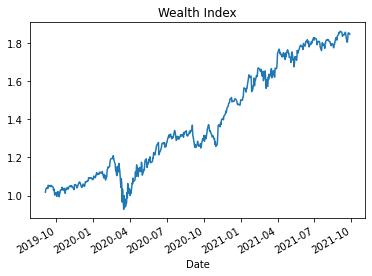

In [5]:
# Out of curiosity, how did our Wealth do?
import matplotlib.pyplot as plt

(returns['portfolio']+1).cumprod().plot()
plt.title('Wealth Index')
plt.show()

In [6]:
# Calculate Historical VaR:

def historicalVaR(returns,alpha=5):
    """
    Read in a pandas dataframe/series of returns
    Returns the percentile of the distribution at given alpha confidence level
    Make it so we return an absolute value - it is typical since everyone knows VaR is losses!
    """
    if isinstance(returns,pd.Series): # If it is a series, return percentile
        return -np.percentile(returns,alpha)
    elif isinstance(returns,pd.DataFrame):
        return returns.aggregate(historicalVaR,alpha=alpha)
    else:
        raise TypeError("Expected returns not DF or Series")

def historicalCVaR(returns,alpha =5):
    """
    Read in a pandas dataframe/series of returns
    Returns the CVaR for dataframe/series of returns , given confidence level alpha
    Make it so we return an absolute value - it is typical since everyone knows VaR is losses!
    """
    if isinstance(returns,pd.Series): # If it is a series, return percentile
        belowVaR = returns <= -historicalVaR(returns,alpha=alpha)
        return -returns[belowVaR].mean()
    elif isinstance(returns,pd.DataFrame):
        return returns.aggregate(historicalCVaR,alpha=alpha)
    else:
        raise TypeError("Expected returns not DF or Series")

In [7]:
historicalVaR(returns)

Symbols
AMZN         0.028325
EA           0.028482
TXN          0.032256
AMAT         0.046872
OKTA         0.047232
GILD         0.026148
TMUS         0.027506
TCOM         0.044275
COST         0.019917
TEAM         0.041317
portfolio    0.023750
dtype: float64

In [8]:
historicalCVaR(returns)

Symbols
AMZN         0.042541
EA           0.044555
TXN          0.052070
AMAT         0.073432
OKTA         0.066782
GILD         0.041029
TMUS         0.045096
TCOM         0.059881
COST         0.030561
TEAM         0.055867
portfolio    0.038643
dtype: float64

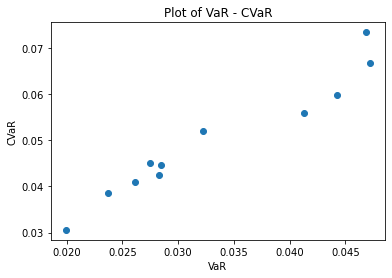

In [9]:
plt.scatter(historicalVaR(returns),historicalCVaR(returns))
plt.title('Plot of VaR - CVaR')
plt.xlabel('VaR')
plt.ylabel('CVaR')
plt.show()

In [10]:
# Let's calculate daily VaR and CVaR for our portfolio of 10 stocks:
Time = 1

VaR = historicalVaR(returns['portfolio'],alpha=5)*np.sqrt(Time)
CVaR = historicalCVaR(returns['portfolio'],alpha=5)*np.sqrt(Time)

# Suppose we have a 1,000,000 dollar investment in this portfolio.

InitialInvestment = 1000000

print('Daily')
print('Value at Risk 95th CI:     ',np.abs(round(InitialInvestment*VaR,2)) , 'dollars')
print('Conditional CVaR 95th CI:     ',np.abs(round(InitialInvestment*CVaR,2)) , 'dollars')

Daily
Value at Risk 95th CI:      23749.55 dollars
Conditional CVaR 95th CI:      38643.36 dollars


### Parametric VaR and CVaR

In [11]:
from scipy.stats import norm,t,skew,kurtosis # import normal and t distributions

def var_parametric(portfolioReturn,portfolioStd,distribution='normal',alpha=5,dof=6):
    """
    Calculate the portfolio VaR given a distribution with known parameters
    """
    if distribution == 'normal':
        VaR = norm.ppf(1-alpha/100)*portfolioStd - portfolioReturn
    elif distribution == 't-distribution':
        VaR = np.sqrt((dof-2)/dof)*t.ppf(1-alpha/100,dof)*portfolioStd - portfolioReturn
    else:
        raise TypeError("Expected distribution to be normal or t-distribution")
    return VaR

def cvar_parametric(portfolioReturn,portfolioStd,distribution='normal',alpha=5,dof=6):
    """
    Calculate the portfolio CVaR given a distribution with known parameters
    """
    if distribution == 'normal':
        CVaR = (alpha/100)**(-1)*norm.pdf(norm.ppf(alpha/100))*portfolioStd - portfolioReturn
    elif distribution == 't-distribution':
        x_ = t.ppf(alpha/100,dof)
        CVaR = -1/(alpha/100)*(1-dof)**(-1)*(dof-2+x_**2)*t.pdf(x_,dof)*portfolioStd - portfolioReturn
    else:
        raise TypeError("Expected distribution to be normal or t-distribution")
    return CVaR

def var_gaussian(r, level=5, modified=False): # Alternative Calculation of Parametric VaR - especially with Cornish-Fischer modification
    """
    Returns the Parametric Gauusian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skew(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [12]:
# VaR Gaussian , VaR with a Cornish Fischer modification
# Rets are: pRets
pRets = returns.iloc[:,:-1]@weights
InitialInvestment*var_gaussian(pRets) , InitialInvestment*var_gaussian(pRets,modified=True) # Notice how similar/disimilar they are, we can infer about the returns distribution. Modified takes kurtosis and skewness into account as well, in the first case, we assume Gaussian distribution of returns

(26084.528910741872, 27143.566468020876)

In [13]:
historicalVaR(pRets)*InitialInvestment , historicalCVaR(pRets)*InitialInvestment

(23749.545975513134, 38643.363803853856)

<AxesSubplot:ylabel='Count'>

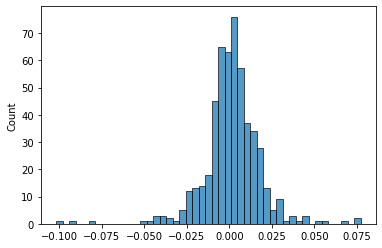

In [14]:
import seaborn as sns
# sns.histplot(data=pRet)
sns.histplot(returns.iloc[:,:-1]@weights)

In [15]:

pRet,pStd = portfolioPerformance(weights,meanReturns,covMatrix,Time)

In [16]:
normVaR = var_parametric(pRet,pStd)
normCVaR = cvar_parametric(pRet,pStd)
tVaR = var_parametric(pRet,pStd,distribution='t-distribution')
tCVaR = cvar_parametric(pRet,pStd,distribution='t-distribution')

In [17]:
# Historical

print('Value at Risk 95th CI:     ',round(InitialInvestment*VaR,2) , 'dollars')
print('Conditional CVaR 95th CI:     ',round(InitialInvestment*CVaR,2) , 'dollars')
print('\n')

# Parametric - Normal
print('Normal VaR 95th CI:     ',round(InitialInvestment*normVaR,2) , 'dollars')
print('Normal CVaR 95th CI:     ',round(InitialInvestment*normCVaR,2) , 'dollars')
print('\n')

# Parametric - T-distribution
print('t-distribution VaR 95th CI:     ',round(InitialInvestment*tVaR,2) , 'dollars')
print('t-distribution CVaR 95th CI:     ',round(InitialInvestment*tCVaR,2) , 'dollars')
print('\n')

# Modified Parametric VaR
print('Cornish-Fisher VaR 95th CI:     ',round(InitialInvestment*var_gaussian(pRets,modified=True),2), 'dollars')

Value at Risk 95th CI:      23749.55 dollars
Conditional CVaR 95th CI:      38643.36 dollars


Normal VaR 95th CI:      26110.86 dollars
Normal CVaR 95th CI:      33078.63 dollars


t-distribution VaR 95th CI:      25139.49 dollars
t-distribution CVaR 95th CI:      34636.95 dollars


Cornish-Fisher VaR 95th CI:      27143.57 dollars


### Monte Carlo Method for Simulations
Basically, a very useful approach for complex problems. Computational simulations that rely on repeated random sampling to obtain results. Pretty similar approach to Historical VaR, we don't assume any distribution of returns for the assets, however we assume that the Assets follow a GBM with a drift etc. In historical VaR we just assume that what happened in the past will continue to happen in the future.This method can become very computationally intensive/complex.

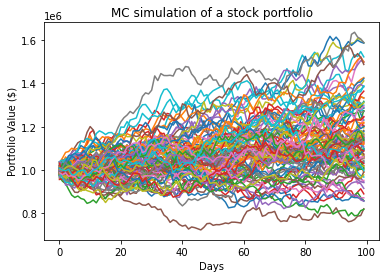

In [18]:
mc_sims = 100 # Number of simulations
T = 100 # time in days

meanM = np.full(shape=(T,len(weights)),fill_value=meanReturns)
meanM = meanM.T

portfolio_sims = np.full(shape=(T,mc_sims),fill_value=0.0)

InitialPortfolio = 1000000 # Let's say we invest 1mil dollars

for m in range(0,mc_sims):
    # Assuming daily returns of our portfolio are distributed by a Multivariate Normal Distribution, we can use Cholesky Decomposition
    Z = np.random.normal(size=(T,len(weights)))
    L = np.linalg.cholesky(covMatrix) # Works out what the lower triangle is for Cholesky decomposition
    dailyReturns = meanM + np.inner(L,Z)
    portfolio_sims[:,m] = np.cumprod((np.inner(weights,dailyReturns.T))+1)*InitialPortfolio
    
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()

### Monte Carlo VaR!

In [19]:
def mcVaR(returns,alpha=5):
    """
    Input: pandas series of returns
    Output: percentile on returns distribution to a given confidence level alpha
    """
    if isinstance(returns,pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")
        
def mcCVaR(returns,alpha=5):
    """
    Input: pandas series of returns
    Output: CVaR or Expected Shortfall to a given confidence level
    """
    if isinstance(returns,pd.Series):
        belowVaR = returns <= mcVaR(returns,alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
        
portResults = pd.Series(portfolio_sims[-1,:])

VaR = InitialPortfolio - mcVaR(portResults,alpha=5)
CVaR = InitialPortfolio - mcCVaR(portResults,alpha=5)

print('VaR ${}'.format(round(VaR,2)))
print('CVaR ${}'.format(round(CVaR,2)))
print('\n')
print(f'The numbers above refer to {T} days VaR and CVaR respectively for our portfolio,in essence we simulated ')

VaR $129081.82
CVaR $157785.41


The numbers above refer to 100 days VaR and CVaR respectively for our portfolio,in essence we simulated 


## Let's generate 100 random portfolios from NASDAQ , each containing 10 stocks at random and compare their VaR - CVaR.

##### Download daily returns for all stocks, then pick 10 at random for each portfolio and weight them equally.

In [20]:
tickers = [i for i in stock_list]

# Define start and end dates, let's take 756 days ( 3 years approximately ) from today.
endDate = dt.datetime.now()
startDate = endDate -dt.timedelta(days=756)

# Download Data
stocks_returns = pdr.get_data_yahoo(tickers,startDate,endDate)


In [21]:
stocks_returns.shape

(522, 612)

In [22]:
# Keep only Adj Close
returns = stocks_returns['Adj Close'].pct_change().dropna()
returns.head()

Symbols,ATVI,ADBE,AMD,ALGN,GOOG,GOOGL,AMZN,AEP,AMGN,ADI,...,KHC,TCOM,VRSN,VRSK,VRTX,WBA,WDAY,XEL,XLNX,ZM
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-27,-0.034858,-0.022092,-0.025450,-0.017599,-0.013130,-0.013153,-0.008271,-0.000955,-0.002252,-0.018561,...,-0.006069,-0.026501,-0.020608,-0.023228,-0.016573,0.006102,-0.033192,-0.003203,-0.013266,-0.046520
2019-09-30,0.011275,-0.004648,0.009401,0.028890,-0.004971,-0.003923,0.006062,-0.005414,-0.007336,0.006214,...,0.003412,0.009304,0.007370,0.016389,0.016073,0.016541,0.007768,-0.007191,-0.000521,0.002104
2019-10-01,-0.000378,-0.012815,-0.007934,0.007628,-0.011403,-0.012398,-0.000150,-0.005017,-0.001654,-0.017453,...,-0.021299,0.018778,-0.024811,-0.010687,-0.010861,-0.011029,-0.007178,0.000924,-0.040250,-0.005118
2019-10-02,-0.012287,-0.022185,-0.015647,-0.013988,-0.023625,-0.023284,-0.012917,-0.011693,-0.020602,-0.007378,...,-0.028895,0.003351,-0.032618,-0.019943,-0.005192,-0.034187,-0.017364,-0.024788,0.004455,-0.025854
2019-10-03,0.034832,0.021526,0.013070,0.027928,0.009519,0.009771,0.006532,0.004016,0.018022,0.017436,...,-0.000377,0.028724,0.019444,0.006326,0.022734,-0.004354,0.037875,0.002052,0.000433,0.040352


In [23]:
# Construct our random portfolios, let's say 100, 10 stocks each

def random_portfolios(returns,n_of_ports=100,n_of_stocks=10,weights="ew"):
    """
    Input: Returns Dataframe of stocks
    Output: Equal(or weighted matrix) weighted returns of a number of random portfolios including a number of stocks
    """
    if weights == "ew":
        weights = 1/n_of_stocks
    ports_ = []
    for i in range(n_of_ports):
        stock_rets = returns.iloc[:,np.random.choice(np.arange(returns.shape[1]),10,replace=False)]
        port_rets = np.sum(stock_rets * weights,axis=1)
        ports_.append(port_rets)
    ports_df = pd.DataFrame(ports_).T
    ports_df.columns = [f"Port{i}" for i in range(1,n_of_ports+1)]
    return ports_df

In [24]:
random_ports = random_portfolios(returns,100,10,"ew")
random_ports.head()

,Port1,Port2,Port3,Port4,Port5,Port6,Port7,Port8,Port9,Port10,...,Port91,Port92,Port93,Port94,Port95,Port96,Port97,Port98,Port99,Port100
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-27,-0.013684,-0.016654,-0.012550,-0.018044,-0.014794,-0.008118,-0.013985,-0.017648,-0.013854,-0.010045,...,-0.017560,-0.019660,-0.028978,-0.013997,-0.014650,-0.023441,-0.023430,-0.009949,-0.017432,-0.013057
2019-09-30,0.013524,0.006926,0.007801,0.006527,0.022075,0.010872,0.008508,0.010115,0.006001,0.011008,...,0.015378,0.009231,0.013948,0.011013,0.007062,0.008116,0.006359,0.007446,0.012305,0.008230
2019-10-01,-0.014070,-0.010253,-0.011974,-0.015563,-0.010380,-0.015361,-0.009852,-0.015517,-0.011030,-0.013784,...,-0.006549,-0.005037,-0.010216,-0.012745,-0.020893,-0.013416,-0.014065,-0.012845,-0.003719,-0.007512
2019-10-02,-0.015334,-0.017783,-0.010788,-0.008163,-0.013141,-0.006523,-0.015668,-0.014737,-0.014173,-0.016421,...,-0.019578,-0.014964,-0.010520,-0.016826,-0.010410,-0.011635,-0.006810,-0.015621,-0.013779,-0.017070
2019-10-03,0.019334,0.006843,0.012700,0.010802,0.014198,0.010639,0.011631,0.018737,0.006472,0.017005,...,0.009553,0.020052,0.021063,0.013535,0.011755,0.012251,0.011465,0.013482,0.017891,0.021583


#### From this point on, we can do plenty of analysis,for now , relevant to this notebook, we will find the Historical VaR and CVaR for each portfolio and compare them

##### Historical

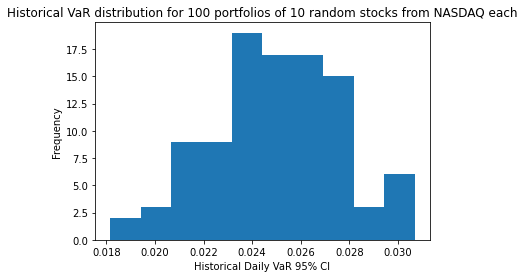

In [25]:
plt.title('Historical VaR distribution for 100 portfolios of 10 random stocks from NASDAQ each')
historicalVaR(random_ports).plot(kind="hist")
plt.xlabel('Historical Daily VaR 95% CI')
plt.show()

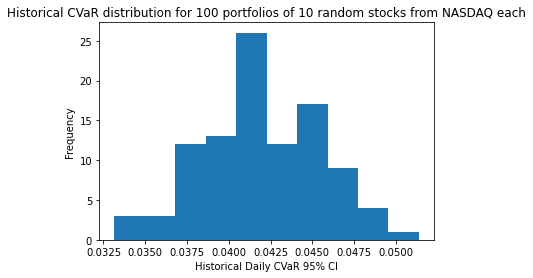

In [26]:
plt.title('Historical CVaR distribution for 100 portfolios of 10 random stocks from NASDAQ each')
historicalCVaR(random_ports).plot(kind="hist")
plt.xlabel('Historical Daily CVaR 95% CI')
plt.show()

##### Parametric
Since here, we assume a distribution of returns ( typically a gaussian ) we will have to relate also on the std of the returns
We will use the gaussian_var function above and present the gaussian and the cornish-fisher modification as well

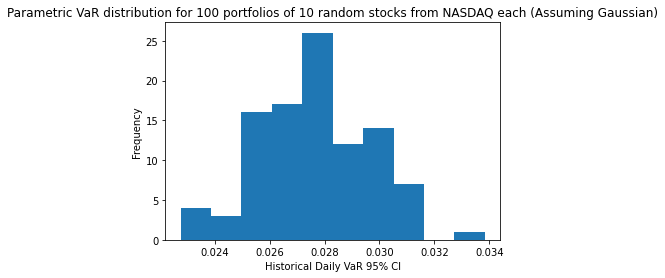

In [27]:
plt.title('Parametric VaR distribution for 100 portfolios of 10 random stocks from NASDAQ each (Assuming Gaussian)')
var_gaussian(random_ports).plot(kind="hist")
plt.xlabel('Historical Daily VaR 95% CI')
plt.show()

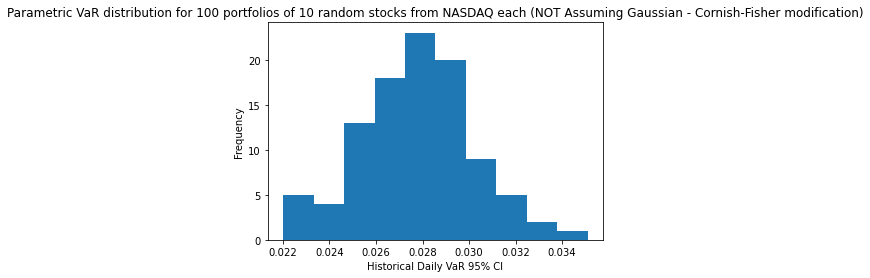

In [28]:
plt.title('Parametric VaR distribution for 100 portfolios of 10 random stocks from NASDAQ each (NOT Assuming Gaussian - Cornish-Fisher modification)')
var_gaussian(random_ports,modified=True).plot(kind="hist")
plt.xlabel('Historical Daily VaR 95% CI')
plt.show()

#### So far: We estimate a VaR of 2-3% in all those random portfolios (of course a larger CVaR) , let's assume a capital of 100 million dollars in each portfolio and calculate the VaR of 30 days. Then we will compare the results with a Monte Carlo VaR methodology, which essentially simulates n-steps ahead for each portfolio and returns a VaR according to those outcomes.

In [29]:
# For portfolio #.
n = 9

init_capital = 100000000 # 100 million $
T = 30 # 30 days

# Historical 30-day VaR
h30var = init_capital*historicalVaR(random_ports.iloc[:,n])*np.sqrt(T)
print(f'Historical 30day-VaR of our 100mil $ portfolio is : {np.round(h30var,2)} $')

# Parametric 30-day VaR
p30var = init_capital*var_gaussian(random_ports.iloc[:,n],modified=False)*np.sqrt(T)
print(f'Parametric 30day-VaR (Assuming Gaussian) of our 100mil $ portfolio is : {np.round(h30var,2)} $')

Historical 30day-VaR of our 100mil $ portfolio is : 12383997.53 $
Parametric 30day-VaR (Assuming Gaussian) of our 100mil $ portfolio is : 12383997.53 $


##### Compare to Monte Carlo VaR : 30 periods ahead! Here, we will model the returns of a portfolio as a Geometric Brownian Motion
In this case, we estimate the performance of the portfolio T steps in the future and conclude about the VaR of our investments!

In [30]:
def gbm(S0,mu,sigma,T,n=252,M=100):
    """
    Inputs:
    S0 : Starting Price of portfolio
    mu : Drift - average of returns annually for example
    sigma : volatility - annual again
    T : time period of simulations
    n : frequency of steps
    M : number of simulations / scenarios
    
    Outputs:
    Returns a dataframe object with the price of asset on each step for each simulation
    """
    
    # Define time step - increment
    dt = T/n
    
    # Geometric Process
    St = np.exp( (mu - sigma ** 2 / 2)*dt 
               + sigma * np.random.normal(0,np.sqrt(dt),size=(M,n)).T
               )
    
    # Include the starting point
    St = np.vstack([np.ones(M),St])
    
    # Multiply them to get each path
    St = S0 * St.cumprod(axis=0)
    
    return pd.DataFrame(St)

In [31]:
mu = random_ports.iloc[:,n].mean()
sigma = random_ports.iloc[:,n].std()

simulations = gbm(init_capital,mu,sigma,30)

<AxesSubplot:>

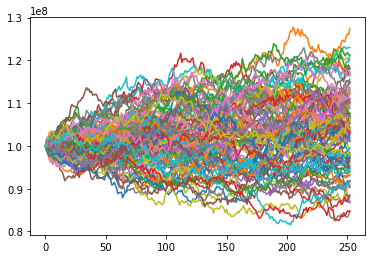

In [32]:
simulations.plot(legend=False)

In [42]:
# According to our Monte Carlo simulation (of course here we assumed our portfolio follows a GBM which is not the case in reality) , we get:
VaR_MC = init_capital - np.percentile(simulations.iloc[-1,:],5)
print(f"Monte Carlo Simulations show a 30-day VaR to be : {np.round(VaR_MC,2)} , dollars")
print('This is only a demonstration of a Monte Carlo simulation, of course more research is required to find the optimal and the correct method to estimate VaR under Monte Carlo simulations approach')

Monte Carlo Simulations show a 30-day VaR to be : 11537935.46 , dollars
This is only a demonstration of a Monte Carlo simulation, of course more research is required to find the optimal and the correct method to estimate VaR under Monte Carlo simulations approach
